In [2]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [3]:
import os
import tempfile
# Use system temp directory for caching
cache_dir = os.path.join(tempfile.gettempdir(), "f1_cache")
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

In [4]:
# Load 2024 Jeddah session
session_2024 = fastf1.get_session(2024, "Saudi Arabia", "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


In [5]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


In [6]:
# Aggregate sector data by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()


In [7]:
sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

In [8]:
# 2025 Bahrain GP quali data (we need to change this before Jeddah)
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "PIA", "LEC", "RUS", "HAM", "GAS", "ALO", "TSU", "SAI", "HUL", "OCO", "STR", "NOR"],
    "QualifyingTime (s)": [87.294, 87.304, 87.670, 87.407, 88.201, 88.367, 88.303, 88.204, 88.164, 88.782, 89.092, 88.645, 87.489]
})


In [9]:
#average lap times for 2025 season of drivers
average_2025 = {
    "VER": 88.0, "PIA": 89.1, "LEC": 89.2, "RUS": 89.3, "HAM": 89.4, 
    "GAS": 89.5, "ALO": 89.6, "TSU": 89.7, "SAI": 89.8, "HUL": 89.9, 
    "OCO": 90.0, "STR": 90.1, "NOR": 90.2
}

In [10]:
# wet driver performance from the script
driver_wet_performance = {
    "VER": 0.975196, "HAM": 0.976464, "LEC": 0.975862, "NOR": 0.978179, "ALO": 0.972655,
    "RUS": 0.968678, "SAI": 0.978754, "TSU": 0.996338, "OCO": 0.981810, "GAS": 0.978832, "STR": 0.979857
}
qualifying_2025["WetPerformanceFactor"] = qualifying_2025["Driver"].map(driver_wet_performance)

In [11]:
API_KEY = "d2585e28290357a9db05c428cdb49ae9"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=21.4225&lon=39.1818&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-04-20 18:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

In [12]:
rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20

In [13]:
# only take into account wet performance if chance is greater than 75% for rain
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [14]:
# Add in Constructor's points because McLaren's on a roll
team_points = {
    "McLaren": 78, "Mercedes": 53, "Red Bull": 36, "Williams": 17, "Ferrari": 17,
    "Haas": 14, "Aston Martin": 10, "Kick Sauber": 6, "Racing Bulls": 3, "Alpine": 0
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}


In [15]:
driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

In [16]:
qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)
qualifying_2025["Average2025Performance"] = qualifying_2025["Driver"].map(average_2025)


In [17]:
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
last_year_winner = "VER" 
merged_data["LastYearWinner"] = (merged_data["Driver"] == last_year_winner).astype(int)

In [18]:
merged_data["QualifyingTime"] = merged_data["QualifyingTime"] ** 2

In [19]:
# Define features
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "TotalSectorTime (s)", "Average2025Performance"
]].fillna(0)
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

In [20]:
clean_data = merged_data.copy()
clean_data["LapTime (s)"] = y.values
clean_data = clean_data.dropna(subset=["LapTime (s)"])

In [21]:
X = clean_data[[
    "QualifyingTime", "TeamPerformanceScore", "RainProbability", "Temperature", "TotalSectorTime (s)", "Average2025Performance"
]]
y = clean_data["LapTime (s)"]

In [22]:
#train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,  max_depth=5, random_state=39)
model.fit(X_train, y_train)
clean_data["PredictedRaceTime (s)"] = model.predict(X)

In [23]:
final_results = clean_data.sort_values("PredictedRaceTime (s)")
print("Predicted 2025 Saudi Arabian GP Winner:")
print(final_results[["Driver", "PredictedRaceTime (s)"]])

Predicted 2025 Saudi Arabian GP Winner:
   Driver  PredictedRaceTime (s)
0     VER              93.567873
1     PIA              94.239782
6     ALO              94.473724
2     LEC              94.551538
3     RUS              94.631787
12    NOR              94.750192
4     HAM              94.828553
11    STR              95.794750
9     HUL              96.816954
10    OCO              97.159957
7     TSU              97.164106


In [24]:
# MAE
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")
print(merged_data)

Model Error (MAE): 0.62 seconds
   Driver  QualifyingTime (s)  WetPerformanceFactor  QualifyingTime  \
0     VER              87.294              0.975196     7620.242436   
1     PIA              87.304                   NaN     7621.988416   
2     LEC              87.670              0.975862     7686.028900   
3     RUS              87.407              0.968678     7639.983649   
4     HAM              88.201              0.976464     7779.416401   
5     GAS              88.367              0.978832     7808.726689   
6     ALO              88.303              0.972655     7797.419809   
7     TSU              88.204              0.996338     7779.945616   
8     SAI              88.164              0.978754     7772.890896   
9     HUL              88.782                   NaN     7882.243524   
10    OCO              89.092              0.981810     7937.384464   
11    STR              88.645              0.979857     7857.936025   
12    NOR              87.489              0.

In [25]:
# compute residuals for each driver
clean_data["Residual"] = clean_data["LapTime (s)"] - clean_data["PredictedRaceTime (s)"]
driver_errors = clean_data.groupby("Driver")["Residual"].mean().sort_values()
print(driver_errors)

Driver
HUL   -1.222188e+00
LEC   -5.052184e-01
VER   -3.587151e-07
ALO   -1.707235e-07
RUS   -1.379206e-07
NOR   -1.195121e-07
HAM   -9.092145e-08
STR    1.034294e-07
OCO    3.723547e-07
TSU    4.020091e-07
PIA    1.390267e-01
Name: Residual, dtype: float64


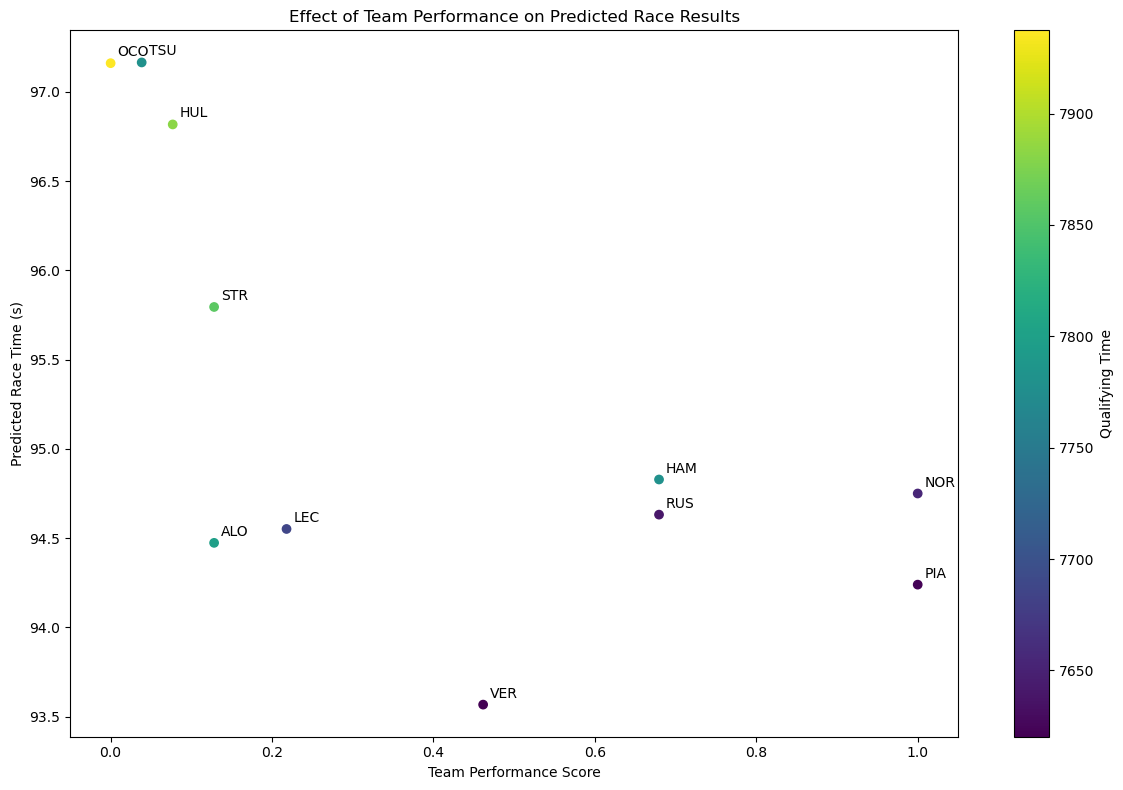

In [26]:
# plot effects of the team performance score
plt.figure(figsize=(12, 8))
plt.scatter(final_results["TeamPerformanceScore"],
            final_results["PredictedRaceTime (s)"],
            c=final_results["QualifyingTime"])

for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["TeamPerformanceScore"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.colorbar(label="Qualifying Time")
plt.xlabel("Team Performance Score")
plt.ylabel("Predicted Race Time (s)")
plt.title("Effect of Team Performance on Predicted Race Results")
plt.tight_layout()
plt.savefig('team_performance_effect.png')
plt.show()

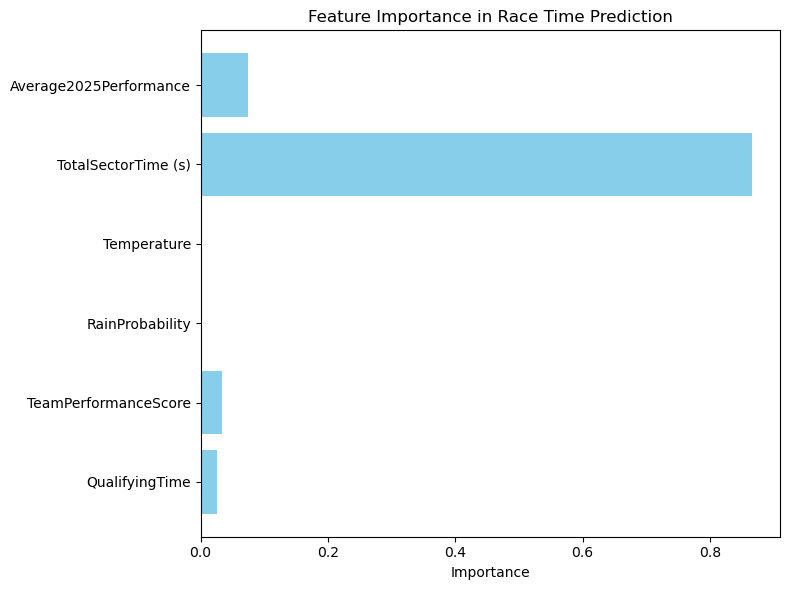

In [27]:
# plot how important each feature is in the model
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

In [29]:
corr_matrix = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "LastYearWinner", "Average2025Performance", "TotalSectorTime (s)"
]].corr()
print(corr_matrix)


                        QualifyingTime  RainProbability  Temperature  \
QualifyingTime                1.000000              NaN          NaN   
RainProbability                    NaN              NaN          NaN   
Temperature                        NaN              NaN          NaN   
TeamPerformanceScore         -0.755855              NaN          NaN   
LastYearWinner               -0.393926              NaN          NaN   
Average2025Performance        0.619695              NaN          NaN   
TotalSectorTime (s)           0.745617              NaN          NaN   

                        TeamPerformanceScore  LastYearWinner  \
QualifyingTime                     -0.755855       -0.393926   
RainProbability                          NaN             NaN   
Temperature                              NaN             NaN   
TeamPerformanceScore                1.000000        0.086186   
LastYearWinner                      0.086186        1.000000   
Average2025Performance             -0.2